# Heat Flux Notebook

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from flox.xarray import xarray_reduce
import gsw

In [4]:
ct_2 = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_2_3.nc')
ct_3 = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_3_3.nc')

In [7]:
ds_diff = xr.open_dataset('/swot/SUM05/amf2288/global_diff.nc')
diff = ds_diff.interp(z_c=ct_2.z_c)
e = ds_diff.e.interp(z_c=ct_2.z_c)

In [8]:
diff

<xarray.Dataset> Size: 87MB
Dimensions:  (z_c: 1001, lon_c: 120, lat_c: 45)
Coordinates:
  * lat_c    (lat_c) float64 360B -66.0 -63.0 -60.0 -57.0 ... 60.0 63.0 66.0
  * lon_c    (lon_c) float64 960B -178.5 -175.5 -172.5 ... 172.5 175.5 178.5
    z_l      (z_c) float64 8kB nan nan nan nan nan nan ... nan nan nan nan nan
    z_r      (z_c) float64 8kB nan nan nan nan nan nan ... nan nan nan nan nan
    lon_l    (lon_c) int64 960B -180 -177 -174 -171 -168 ... 165 168 171 174 177
    lon_r    (lon_c) int64 960B -177 -174 -171 -168 -165 ... 168 171 174 177 180
    lat_l    (lat_c) float64 360B -67.5 -64.5 -61.5 -58.5 ... 58.5 61.5 64.5
    lat_r    (lat_c) float64 360B -64.5 -61.5 -58.5 -55.5 ... 61.5 64.5 67.5
  * z_c      (z_c) int64 8kB 0 2 4 6 8 10 12 ... 1990 1992 1994 1996 1998 2000
Data variables:
    K        (z_c, lon_c, lat_c) float64 43MB nan nan nan nan ... nan nan nan
    e        (z_c, lon_c, lat_c) float64 43MB nan nan nan nan ... nan nan nan

In [53]:
dCTe_dz = ct_2.differentiate('z_c')
dCTm_dx = ct_3.differentiate('lon_c')
dCTm_dy = ct_3.differentiate('lat_c')

In [54]:
uT = (K_rho*dCT_dz**2)/dCT_dx
vT = (K_rho*dCT_dz**2)/dCT_dy

In [55]:
depth = 1000

In [56]:
lon = -25

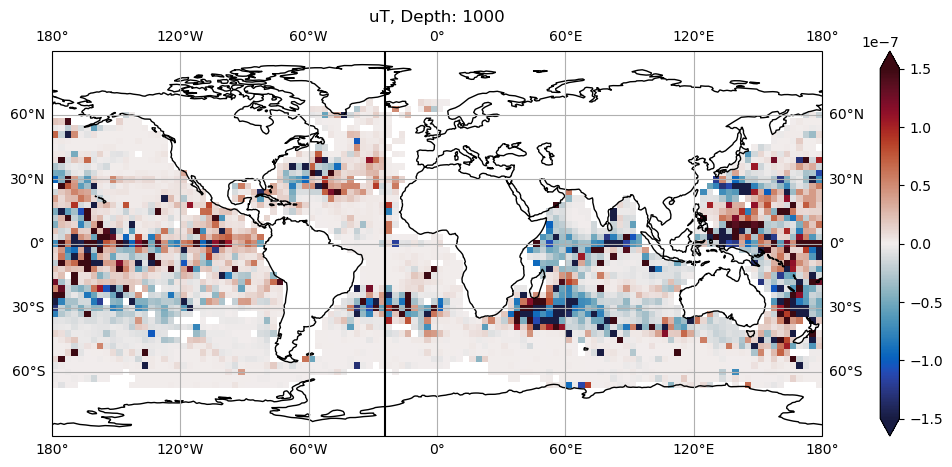

In [61]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
uT.sel(z_c=depth, method='nearest').plot(x='lon_c', y='lat_c', ax=ax, transform=ccrs.PlateCarree(), cmap=cmo.balance, vmin=-1.5e-7, vmax=1.5e-7)
ax.axvline(-24.5, color='k')
ax.set_title('uT, Depth: {}'.format(depth));

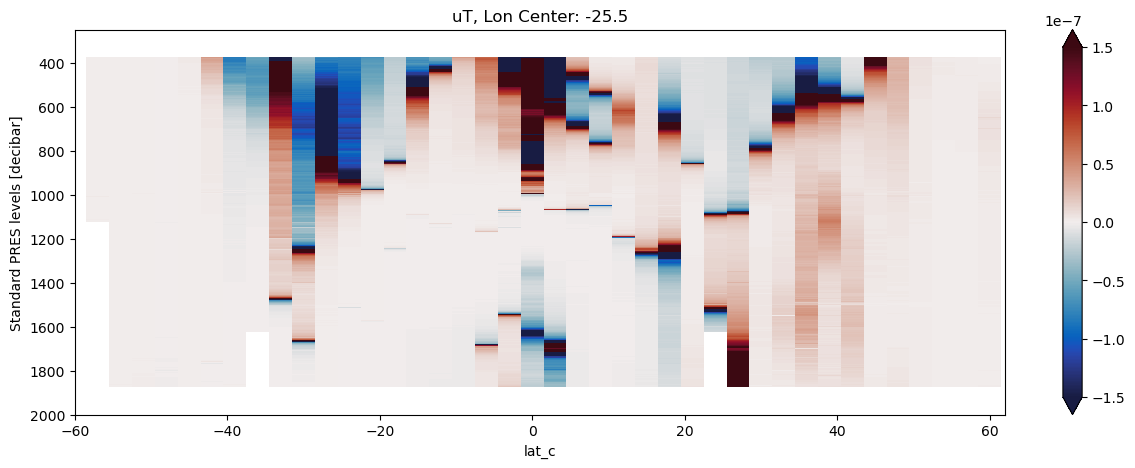

In [58]:
fig=plt.figure(figsize=(15,5))
uT.sel(lon_c=lon, method='nearest').plot(x='lat_c',y='z_c', cmap=cmo.balance, vmin=-1.5e-7, vmax=1.5e-7)
plt.gca().invert_yaxis()
plt.xlim(-60,62)
plt.ylim(2000,250)
plt.title('uT, Lon Center: {}'.format(uT.sel(lon_c=lon, method='nearest').lon_c.values));

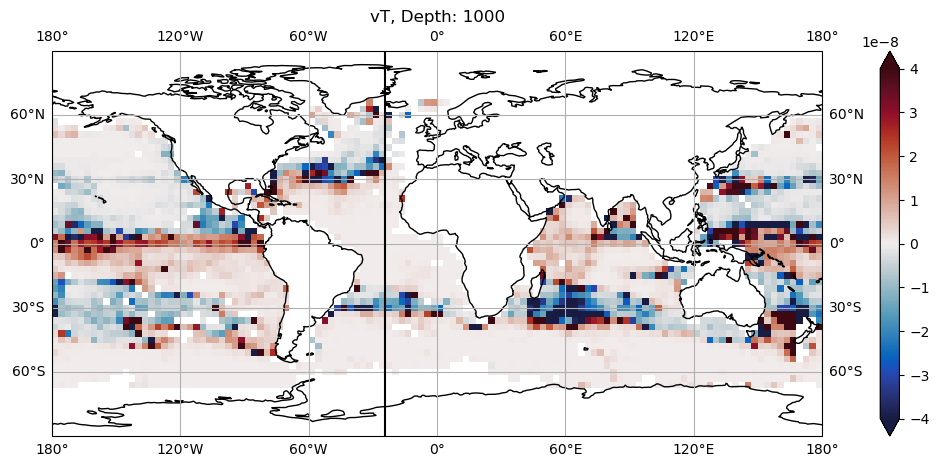

In [62]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
vT.sel(z_c=depth, method='nearest').plot(x='lon_c', y='lat_c', ax=ax, transform=ccrs.PlateCarree(), cmap=cmo.balance, vmin=-4e-8, vmax=4e-8)
ax.axvline(-24.5, color='k')
ax.set_title('vT, Depth: {}'.format(depth));

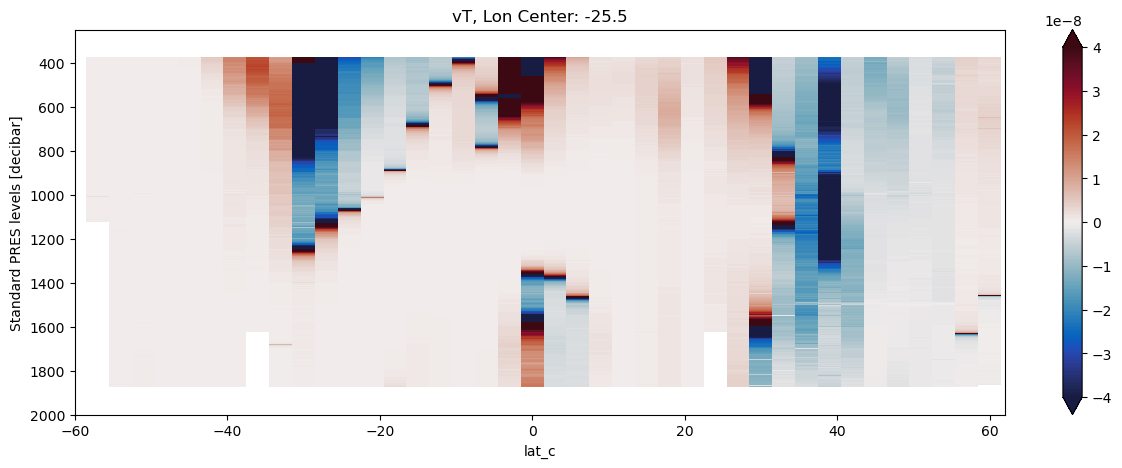

In [60]:
fig=plt.figure(figsize=(15,5))
vT.sel(lon_c=lon, method='nearest').plot(x='lat_c',y='z_c', cmap=cmo.balance, vmin=-4e-8, vmax=4e-8)
plt.gca().invert_yaxis()
plt.xlim(-60,62)
plt.ylim(2000,250)
plt.title('vT, Lon Center: {}'.format(uT.sel(lon_c=lon, method='nearest').lon_c.values));